# Housekeeping (Importing libraries, loading datasets)

In [42]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import qmc

In [13]:
# secured overnight financing rate, sourced from the st. louis fred
sofr = pd.read_csv('data/FRED_SOFR.csv', parse_dates=['DATE'], index_col='DATE')

In [14]:
sofr.head()

,SOFR
DATE,
2018-04-03,1.83
2018-04-04,1.74
2018-04-05,1.75
2018-04-06,1.75
2018-04-09,1.75


In [15]:
sofr.tail()

,SOFR
DATE,
2024-10-28,4.82
2024-10-29,4.82
2024-10-30,4.81
2024-10-31,4.9
2024-11-01,4.86


In [16]:
# Load Market Yield on U.S. Treasury Securities at X-Year Constant Maturity, Quoted on an Investment Basis
dgs1 = pd.read_csv('data/DGS1.csv', parse_dates=['DATE'], index_col='DATE')
dgs2 = pd.read_csv('data/DGS2.csv', parse_dates=['DATE'], index_col='DATE')
dgs5 = pd.read_csv('data/DGS5.csv', parse_dates=['DATE'], index_col='DATE')
dgs10 = pd.read_csv('data/DGS10.csv', parse_dates=['DATE'], index_col='DATE')
dgs30 = pd.read_csv('data/DGS30.csv', parse_dates=['DATE'], index_col='DATE')

# combine them all
yc = pd.concat([dgs1.rename(columns={'DGS1': '1Y'}),
                              dgs2.rename(columns={'DGS2': '2Y'}),
                              dgs5.rename(columns={'DGS5': '5Y'}),
                              dgs10.rename(columns={'DGS10': '10Y'}),
                              dgs30.rename(columns={'DGS30': '30Y'})], axis=1)

In [17]:
yc.head()

,1Y,2Y,5Y,10Y,30Y
DATE,,,,,
1962-01-02,3.22,NaN,3.88,4.06,NaN
1962-01-03,3.24,NaN,3.87,4.03,NaN
1962-01-04,3.24,NaN,3.86,3.99,NaN
1962-01-05,3.26,NaN,3.89,4.02,NaN
1962-01-08,3.31,NaN,3.91,4.03,NaN


In [18]:
yc.tail()

,1Y,2Y,5Y,10Y,30Y
DATE,,,,,
2024-10-25,4.29,4.11,4.07,4.25,4.51
2024-10-28,4.28,4.12,4.11,4.28,4.53
2024-10-29,4.29,4.11,4.11,4.28,4.52
2024-10-30,4.28,4.15,4.14,4.29,4.49
2024-10-31,4.27,4.16,4.15,4.28,4.47


# I. Exploratory Data Analysis & Visualization

In [20]:
# check formissing values and prepare for imputation
print("\nMissing values in SOFR Data:", sofr.isna().sum())
print("Missing values in Yield Curve Data:", yc.isna().sum())


Missing values in SOFR Data: SOFR    0
dtype: int64
Missing values in Yield Curve Data: 1Y        0
2Y     3760
5Y        0
10Y       0
30Y    3945
dtype: int64


In [21]:
print("\nSOFR Summary Statistics:")
print(sofr.describe())


SOFR Summary Statistics:
        SOFR
count   1719
unique   188
top     0.05
freq     188


In [22]:
print("\nYield Curve Summary Statistics:")
print(yc.describe())


Yield Curve Summary Statistics:
           1Y     2Y     5Y    10Y    30Y
count   16393  12633  16393  16393  12448
unique   1896   1873   1468   1403   1323
top         .      .      .      .      .
freq      698    530    698    698    523


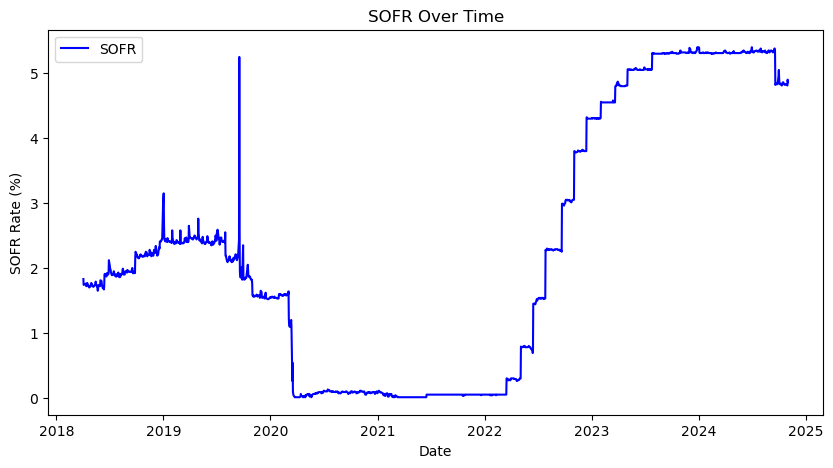

In [29]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Plot SOFR over time
plt.figure(figsize=(10, 5))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='blue')
plt.title("SOFR Over Time")
plt.xlabel("Date")
plt.ylabel("SOFR Rate (%)")
plt.legend()
plt.show()

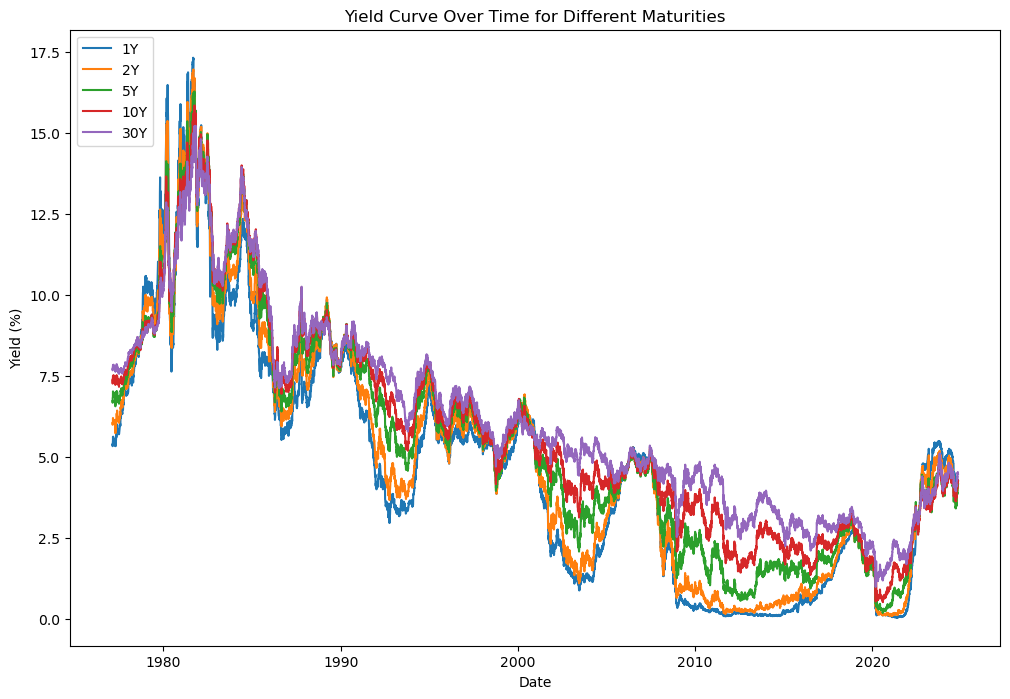

In [30]:
# Ensure all yield curve columns are numeric and handle any non-numeric values
for col in yc.columns:
    yc[col] = pd.to_numeric(yc[col], errors='coerce')

# Drop rows with NaN values or interpolate
yc = yc.interpolate(method='time').dropna()  # Interpolate missing values based on time index

# Plot yield curve maturities
plt.figure(figsize=(12, 8))
for col in yc.columns:
    plt.plot(yc.index, yc[col], label=col)
    
plt.title("Yield Curve Over Time for Different Maturities")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend(loc='upper left')
plt.show()

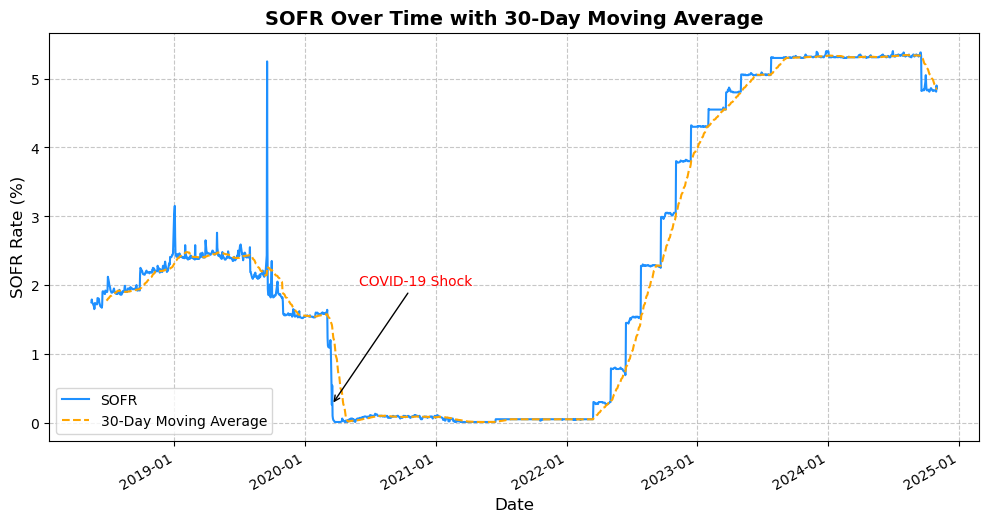

In [36]:
# Ensure SOFR data is numeric and drop any non-numeric rows (if any)
sofr['SOFR'] = pd.to_numeric(sofr['SOFR'], errors='coerce')
sofr = sofr.dropna()  # Drop rows where SOFR might be NaN after conversion

# Calculate a 30-day moving average for SOFR
sofr['SOFR_MA'] = sofr['SOFR'].rolling(window=30).mean()

# Set up the plot
plt.figure(figsize=(12, 6))
plt.plot(sofr.index, sofr['SOFR'], label='SOFR', color='dodgerblue')
plt.plot(sofr.index, sofr['SOFR_MA'], label='30-Day Moving Average', color='orange', linestyle='--')

# Convert annotation date to datetime format
annot_date = datetime(2020, 3, 16)  # Example annotation date for COVID-19

# Annotating a significant date (COVID-19 impact on rates as an example)
plt.annotate('COVID-19 Shock', 
             xy=(annot_date, sofr.loc[annot_date, 'SOFR']), 
             xytext=(datetime(2020, 6, 1), 2.0),
             arrowprops=dict(facecolor='red', arrowstyle='->'), color='red')

# Beautify the plot
plt.title("SOFR Over Time with 30-Day Moving Average", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("SOFR Rate (%)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Formatting the x-axis to show year and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show ticks every year
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()

In [32]:
# Prepare data for 3D plotting
# Convert dates to numerical values for the x-axis
time_values = np.arange(len(yc.index))
maturity_values = [1, 2, 5, 10, 30]  # Maturities in years
yield_values = yc.values.T  # Transpose to get maturities as rows for z-axis

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=yield_values, x=time_values, y=maturity_values, colorscale='Viridis')])
fig.update_layout(title="3D Surface Plot of Yield Curve Over Time",
                  scene=dict(xaxis_title='Time', yaxis_title='Maturity (Years)', zaxis_title='Yield (%)'),
                  autosize=False, width=800, height=600)
fig.show()

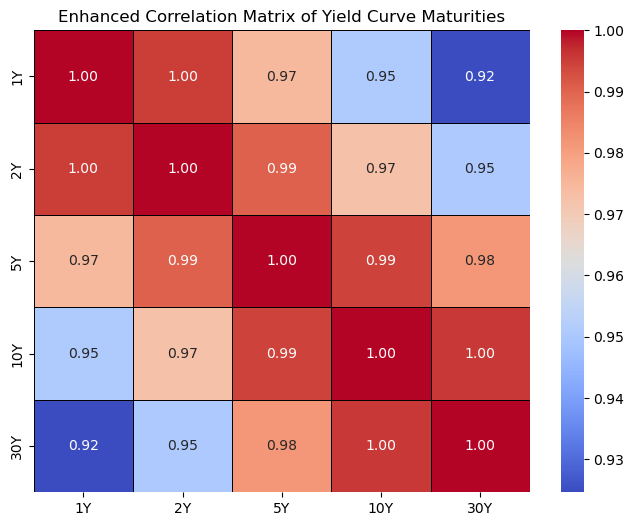

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(yc.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            annot_kws={"size": 10}, linewidths=0.5, linecolor='black')
plt.title("Enhanced Correlation Matrix of Yield Curve Maturities")
plt.show()

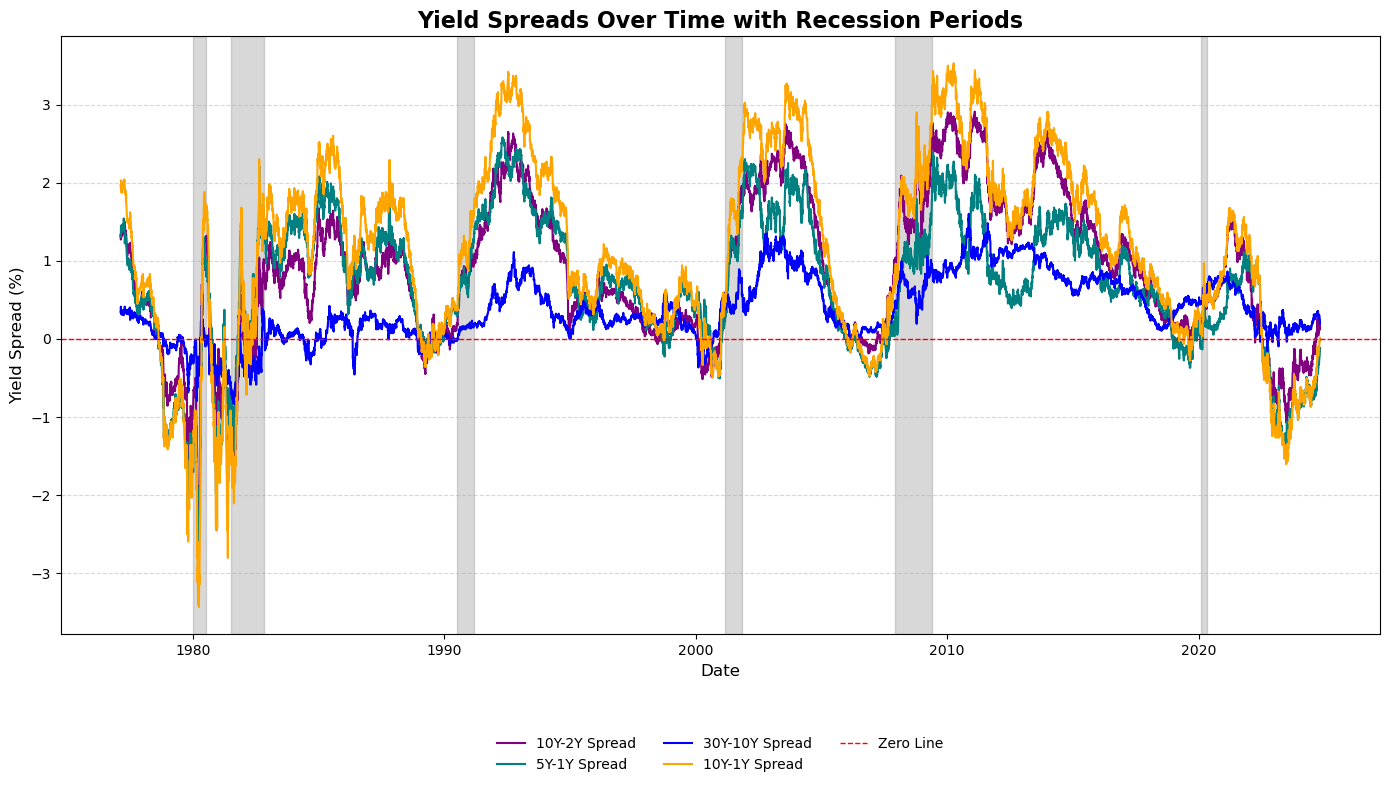

In [41]:
recession_periods = [
    ('1969-12-01', '1970-11-01'),
    ('1973-11-01', '1975-03-01'),
    ('1980-01-01', '1980-07-01'),
    ('1981-07-01', '1982-11-01'),
    ('1990-07-01', '1991-03-01'),
    ('2001-03-01', '2001-11-01'),
    ('2007-12-01', '2009-06-01'),
    ('2020-02-01', '2020-05-01')  # COVID-19 recession
]

# Define the start date for plotting
start_date = '1975-01-01'

# Filter data starting from the specified start date
filtered_yc = yc[yc.index >= start_date]

# Calculate yield spreads if not already calculated
filtered_yc['10Y-2Y Spread'] = filtered_yc['10Y'] - filtered_yc['2Y']
filtered_yc['5Y-1Y Spread'] = filtered_yc['5Y'] - filtered_yc['1Y']
filtered_yc['30Y-10Y Spread'] = filtered_yc['30Y'] - filtered_yc['10Y']
filtered_yc['10Y-1Y Spread'] = filtered_yc['10Y'] - filtered_yc['1Y']

# Create the plot with enhanced styling
plt.figure(figsize=(14, 8))

# Plot each spread with different styles and colors
plt.plot(filtered_yc.index, filtered_yc['10Y-2Y Spread'], color='purple', label='10Y-2Y Spread')
plt.plot(filtered_yc.index, filtered_yc['5Y-1Y Spread'], color='teal', label='5Y-1Y Spread')
plt.plot(filtered_yc.index, filtered_yc['30Y-10Y Spread'], color='blue', label='30Y-10Y Spread')
plt.plot(filtered_yc.index, filtered_yc['10Y-1Y Spread'], color='orange', label='10Y-1Y Spread')

# Add a horizontal line at zero to indicate spread inversion
plt.axhline(0, color='red', linestyle='--', label='Zero Line', linewidth=1)

# Mark recession periods with shaded regions
for start, end in recession_periods:
    if start >= start_date:  # Only mark recessions within the filtered date range
        plt.axvspan(start, end, color='gray', alpha=0.3)

# Enhance plot aesthetics
plt.title("Yield Spreads Over Time with Recession Periods", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Yield Spread (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Only show horizontal grid lines to reduce clutter

# Adjust legend positioning
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10, frameon=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

# II: Construction of Forward Rate Curves

# III. Analysis of Yield Curve Movements using PCA

# IV: Stochastic Modeling with the HJM Framework